Load data

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
path_main='drive/MyDrive/Grapevine_Leaves_Image_Dataset/'
path_Ak = path_main + 'Ak'
path_Ala_Idris = path_main + 'Ala_Idris'
path_Buzgulu = path_main + 'Buzgulu'
path_Dimnit = path_main + 'Dimnit'
path_Nazli = path_main + 'Nazli'

In [2]:
import pandas as pd
import os

In [3]:
Classes = ['Ak', 'Ala_Idris','Buzgulu', 'Dimnit','Nazli']
for label in Classes:
    print(f"{label}: {len(os.listdir(os.path.join(path_main, label)))} images")


Ak: 100 images
Ala_Idris: 100 images
Buzgulu: 100 images
Dimnit: 100 images
Nazli: 100 images


In [4]:
df = pd.DataFrame()

In [5]:
df['image'] = os.listdir(path_Ak) + os.listdir(path_Ala_Idris) + os.listdir(path_Buzgulu) + os.listdir(path_Dimnit) + os.listdir(path_Nazli)

In [6]:
classes = []
paths = []
for img in df['image']:
    cls = img.split(' (')[0]
    classes.append(cls)
    paths.append(path_main+cls+'/'+img)


In [7]:
df['class'] = classes
df['path'] = paths

Split Data into train and test and validation

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['path','class']], df[['class']], test_size=0.2, random_state=42)

In [10]:
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Augment Data

In [15]:
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

data_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.5, 1.5],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input) 

train_generator= data_generator.flow_from_dataframe(
        X_train,  
        x_col='path',
        y_col='class',
        target_size=(227, 227), 
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

val_generator = data_generator.flow_from_dataframe(
        X_val, 
        x_col='path',
        y_col='class',
        target_size=(227, 227), 
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
test_generator = test_data_generator.flow_from_dataframe(
        X_test,  
        x_col='path',
        y_col='class',
        target_size=(227, 227), 
        batch_size=32,
        class_mode="categorical",
        shuffle=False,
)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


Show Augment image

In [16]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

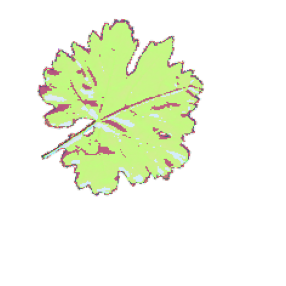

In [17]:
path = np.random.choice(df['path'],1)[0]
plt.figure(figsize = (5,5))
data = Image.open(path)
data = data.resize((224,224))
samples = np.expand_dims(data, 0)
it = data_generator.flow(samples, batch_size=1)
batch = it.next()
image = batch[0].astype('uint8')
plt.imshow(image)
plt.axis('off')
plt.show()

CNN Models

Functions for plot results

In [18]:
def AccuracyResult(history_Model):
  plt.figure(figsize=(10,5))
  plt.plot(history_Model.history['accuracy'])
  plt.plot(history_Model.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()

In [19]:
def LossResult(history_Model):
  plt.figure(figsize=(10,5))
  plt.plot(history_Model.history['loss'])
  plt.plot(history_Model.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.show()

Vgg Model

In [20]:
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from keras.layers import GlobalAveragePooling2D 

In [21]:
vgg = VGG19(include_top = False, input_shape = (227,227,3), weights = 'imagenet')


for layer in vgg.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(vgg.output)
predictions = Dense(5, activation='softmax')(x)

model_vgg = Model(inputs = vgg.input, outputs = predictions)

model_vgg.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

history_vgg = model_vgg.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    verbose=2,
)

Epoch 1/40
10/10 - 16s - loss: 2.3291 - accuracy: 0.2250 - val_loss: 1.7374 - val_accuracy: 0.3250 - 16s/epoch - 2s/step
Epoch 2/40
10/10 - 9s - loss: 1.8243 - accuracy: 0.3000 - val_loss: 1.6238 - val_accuracy: 0.3625 - 9s/epoch - 854ms/step
Epoch 3/40
10/10 - 9s - loss: 1.6070 - accuracy: 0.3281 - val_loss: 1.5673 - val_accuracy: 0.3750 - 9s/epoch - 935ms/step
Epoch 4/40
10/10 - 9s - loss: 1.4591 - accuracy: 0.4062 - val_loss: 1.5457 - val_accuracy: 0.3625 - 9s/epoch - 862ms/step
Epoch 5/40
10/10 - 9s - loss: 1.3475 - accuracy: 0.4531 - val_loss: 1.3533 - val_accuracy: 0.4250 - 9s/epoch - 855ms/step
Epoch 6/40
10/10 - 9s - loss: 1.3036 - accuracy: 0.4812 - val_loss: 1.2685 - val_accuracy: 0.4875 - 9s/epoch - 856ms/step
Epoch 7/40
10/10 - 9s - loss: 1.2044 - accuracy: 0.4812 - val_loss: 1.1419 - val_accuracy: 0.5250 - 9s/epoch - 857ms/step
Epoch 8/40
10/10 - 9s - loss: 1.1084 - accuracy: 0.5656 - val_loss: 1.1578 - val_accuracy: 0.5625 - 9s/epoch - 858ms/step
Epoch 9/40
10/10 - 12s - 

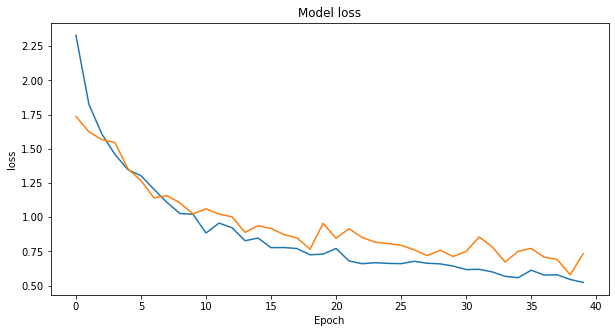

In [22]:
LossResult(history_vgg)

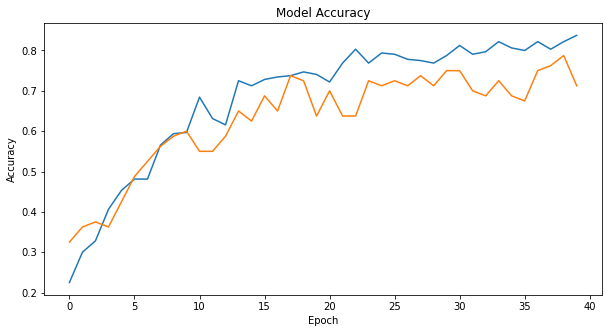

In [23]:
AccuracyResult(history_vgg)

In [24]:
model_vgg.evaluate(test_generator)

4/4 [==============================] - 2s 483ms/step - loss: 0.7611 - accuracy: 0.7900


[0.7611285448074341, 0.7900000214576721]

Resnet50

In [31]:
from tensorflow.keras.applications import ResNet50

In [32]:
resnet_Model = ResNet50(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

for layer in resnet_Model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet_Model.output)
predictions = Dense(5, activation='softmax')(x)

resnet_Model= Model(inputs = resnet_Model.input, outputs = predictions)
resnet_Model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history_resnet = resnet_Model.fit(
      train_generator,
      validation_data=val_generator,
      epochs=40,
      verbose=2)

Epoch 1/40
10/10 - 13s - loss: 1.8017 - accuracy: 0.2250 - val_loss: 1.5620 - val_accuracy: 0.3125 - 13s/epoch - 1s/step
Epoch 2/40
10/10 - 10s - loss: 1.5493 - accuracy: 0.3375 - val_loss: 1.4425 - val_accuracy: 0.3875 - 10s/epoch - 1s/step
Epoch 3/40
10/10 - 10s - loss: 1.3804 - accuracy: 0.4500 - val_loss: 1.2887 - val_accuracy: 0.4500 - 10s/epoch - 1s/step
Epoch 4/40
10/10 - 19s - loss: 1.2481 - accuracy: 0.5594 - val_loss: 1.2310 - val_accuracy: 0.6000 - 19s/epoch - 2s/step
Epoch 5/40
10/10 - 12s - loss: 1.1502 - accuracy: 0.5844 - val_loss: 1.0990 - val_accuracy: 0.6000 - 12s/epoch - 1s/step
Epoch 6/40
10/10 - 8s - loss: 1.0500 - accuracy: 0.6500 - val_loss: 1.0372 - val_accuracy: 0.6750 - 8s/epoch - 824ms/step
Epoch 7/40
10/10 - 8s - loss: 0.9989 - accuracy: 0.6719 - val_loss: 0.9826 - val_accuracy: 0.7500 - 8s/epoch - 825ms/step
Epoch 8/40
10/10 - 8s - loss: 0.9521 - accuracy: 0.7219 - val_loss: 0.9700 - val_accuracy: 0.6500 - 8s/epoch - 826ms/step
Epoch 9/40
10/10 - 8s - loss:

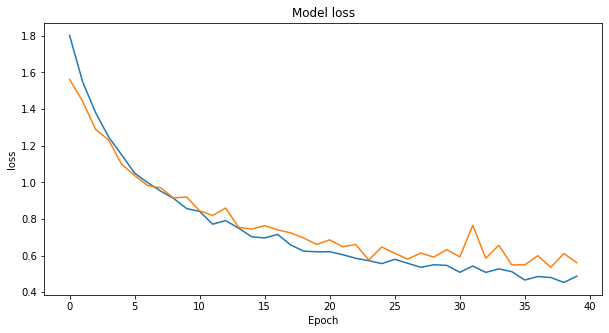

In [33]:
LossResult(history_resnet)

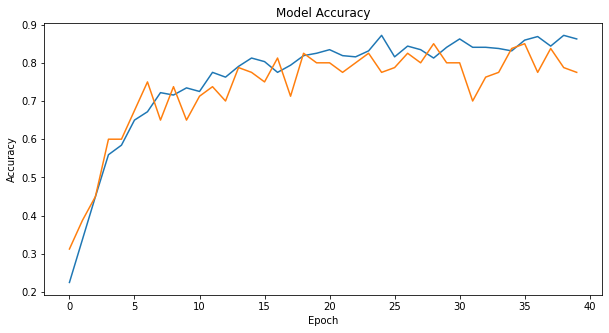

In [34]:
AccuracyResult(history_resnet)

In [35]:
resnet_Model.evaluate(test_generator)

4/4 [==============================] - 1s 310ms/step - loss: 0.6680 - accuracy: 0.7200


[0.6679686903953552, 0.7200000286102295]

MobileNet

In [37]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [38]:
Mob_Model = MobileNetV2(include_top = False, input_shape = (224,224,3), weights = 'imagenet')

for layer in Mob_Model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(Mob_Model.output)
predictions = Dense(5, activation='softmax')(x)
Mob_Model = Model(inputs = Mob_Model.input, outputs = predictions)
Mob_Model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

history_Mob = Mob_Model.fit(
      train_generator,
      validation_data = val_generator,
      epochs=40,
)

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/40
10/10 [==============================] - 12s 961ms/step - loss: 1.7299 - accuracy: 0.2781 - val_loss: 1.7957 - val_accuracy: 0.2500
Epoch 2/40
10/10 [==============================] - 8s 813ms/step - loss: 1.4363 - accuracy: 0.3781 - val_loss: 1.3726 - val_accuracy: 0.4500
Epoch 3/40
10/10 [==============================] - 8s 808ms/step - loss: 1.3729 - accuracy: 0.4219 - val_loss: 1.3521 - val_accuracy: 0.4375
Epoch 4/40
10/10 [==============================] - 8s 807ms/step - loss: 1.2439 - accuracy: 0.4656 - val_loss: 1.2540 - val_accuracy: 0.5375
Epoch 5/40
10/10 [==============================] - 8s 808ms/step - loss: 1.1729 - accuracy: 0.5250 - val_loss: 1.1327 - val_accuracy: 0.5500
Epoch 6/40
10/10 [==============================] - 8s 818ms/step - loss: 1.0958 - accuracy: 0.5531 - val_loss: 1.1049 - val_accuracy: 0.6000
Epoch 7/40
10/10 [==============================] - 9s 945ms/step - loss: 1.1107 - a

In [39]:
predict_Mob = Mob_Model.predict(test_generator)

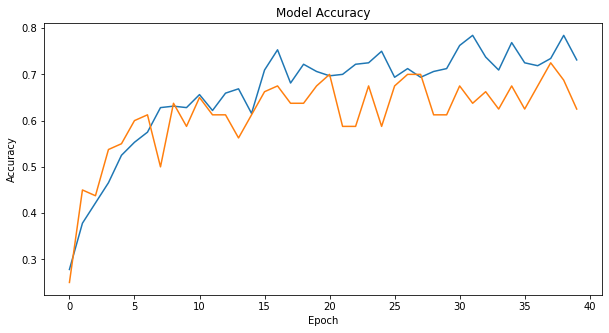

In [40]:
AccuracyResult(history_Mob)

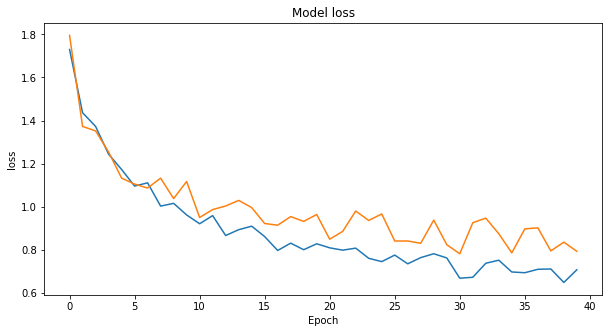

In [41]:
LossResult(history_Mob)

In [42]:
Mob_Model.evaluate(test_generator)

4/4 [==============================] - 1s 168ms/step - loss: 0.7146 - accuracy: 0.7900


[0.7145947217941284, 0.7900000214576721]

Denoising

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
dataset=[]
count=0
for file in os.listdir(path_main):
    path=os.path.join(path_main,file)
    for im in os.listdir(path):
        image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(224,224))
        image=img_to_array(image)
        image=image/255.0
        dataset.append([image,count])
    count=count+1
data,labels0=zip(*dataset)
labels1=to_categorical(labels0)
X=np.array(data)
y=np.array(labels1)
X = X.reshape(-1,224,224,3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
noise_factor = 0.4
X_train,X_valid,y_train,y_valid = train_test_split(X_train, y_train, test_size=0.2)

X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size = X_train.shape) 
X_valid_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size = X_valid.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size = X_test.shape) 
X_train_noisy = np.clip(X_train_noisy, 0., 1)
X_test_noisy = np.clip(X_test_noisy, 0., 1)
X_valid_noisy = np.clip(X_valid_noisy, 0., 1)

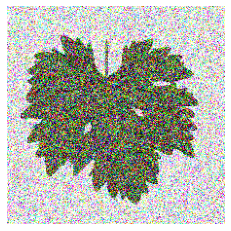

In [ ]:
plt.imshow(X_test_noisy[0])
plt.axis('off')
plt.show()

Autoencoder

In [ ]:
import tensorflow as tf


In [ ]:
from keras.layers import Conv2D ,Conv2DTranspose,UpSampling2D

In [ ]:
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.models import Sequential, Model
def autoencoder(train_generator, eps, optimizer):
  model = Sequential()

  # encoder network
  model.add(Conv2D(15, 3, activation= 'relu', padding='same', input_shape = (227,227,3)))
  model.add(AveragePooling2D(2, padding= 'same'))
  model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
  model.add(AveragePooling2D(2, padding= 'same'))
  model.add(Dense(512,activation='relu'))

  #decoder network
  model.add(Conv2DTranspose(15, 3, activation= 'relu', padding='same'))
  model.add(UpSampling2D(2))
  model.add(Conv2DTranspose(15, 3, activation= 'relu', padding='same'))
  model.add(UpSampling2D(2))
  model.add(Conv2DTranspose(3,3,activation='sigmoid', padding= 'same')) 
 
  model.compile(optimizer=optimizer,loss='mse',metrics=['accuracy'])

  fitted_model = model.fit(train_generator, train_generator, validation_split=0.1, epochs=eps)

  for epoch in range(eps):
    temptrain = train_generator.next()[0]
    history = model.fit(
      temptrain,
      temptrain,
      epochs=10, 
      batch_size=32,
      validation_split=0.10,
      steps_per_epoch=5,
    )   
  model.predict(X_test_noisy)


In [ ]:
#autoencoder(X_train_noisy, 50, 'adam')

Confusion matrix

In [28]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def results(model, y_test, y_predict):
    y_predict = np.argmax(y_predict, axis= 1)
    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    y_predict =np.array([labels[k] for k in y_predict])
    print(classification_report(y_test,y_predict))
    cm = confusion_matrix(y_test , y_predict)
    sns.heatmap(cm, annot = True)


In [29]:
y_predict_vgg = model_vgg.predict(test_generator)

Accuracy : 0.79
              precision    recall  f1-score   support

          Ak       0.95      0.68      0.79        28
   Ala_Idris       0.86      0.86      0.86        14
     Buzgulu       0.62      0.80      0.70        10
      Dimnit       0.64      0.88      0.74        24
       Nazli       0.95      0.79      0.86        24

    accuracy                           0.79       100
   macro avg       0.80      0.80      0.79       100
weighted avg       0.83      0.79      0.80       100



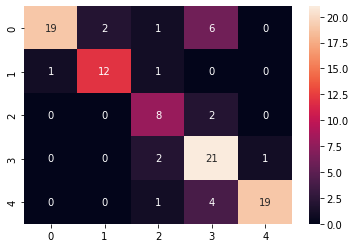

In [30]:
results(model_vgg, np.array(y_test['class']), y_predict_vgg)

Accuracy : 0.72
              precision    recall  f1-score   support

          Ak       0.93      0.50      0.65        28
   Ala_Idris       0.52      0.79      0.63        14
     Buzgulu       0.45      0.90      0.60        10
      Dimnit       0.78      0.75      0.77        24
       Nazli       0.95      0.83      0.89        24

    accuracy                           0.72       100
   macro avg       0.73      0.75      0.71       100
weighted avg       0.80      0.72      0.73       100



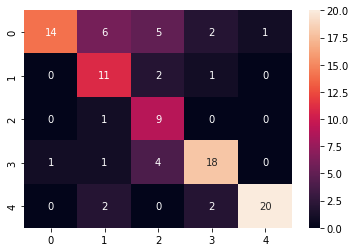

In [36]:
y_predict_resnet = resnet_Model.predict(test_generator)
results(resnet_Model, np.array(y_test['class']), y_predict_resnet)

Accuracy : 0.79
              precision    recall  f1-score   support

          Ak       0.83      0.71      0.77        28
   Ala_Idris       1.00      0.79      0.88        14
     Buzgulu       0.64      0.70      0.67        10
      Dimnit       0.70      0.88      0.78        24
       Nazli       0.83      0.83      0.83        24

    accuracy                           0.79       100
   macro avg       0.80      0.78      0.79       100
weighted avg       0.80      0.79      0.79       100



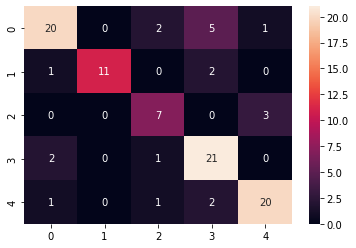

In [43]:
y_predict_mobile = Mob_Model.predict(test_generator)
results(Mob_Model, np.array(y_test['class']), y_predict_mobile)